# 🎯 Objectif du projet : Inférence variationnelle stochastique pour LDA

Cette section détaille le **projet d’application de l’article** *Stochastic Variational Inference*, en l'appliquant au modèle de **Latent Dirichlet Allocation (LDA)** pour l’analyse thématique de documents.
# 1. Récupération de documents Wikipedia

On sélectionne quelques sujets afin de constituer un petit corpus de textes.

In [2]:
import wikipedia
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Choix des sujets Wikipedia à extraire
topics = ["geography", "data science", "philosophy"]

# Récupération des résumés Wikipedia
documents = []
for topic in topics:
    try:
        summary = wikipedia.page(topic, auto_suggest=True).content  # Utilise l'auto-suggestion pour trouver la page la plus pertinente
        documents.append(summary)
    except Exception as e:
        print(f"Erreur pour le sujet {topic}: {e}")
        documents.append("")

# 2. Vectorisation (bag-of-words)

Les documents sont transformés en une matrice terme-document, avec suppression des stop words.

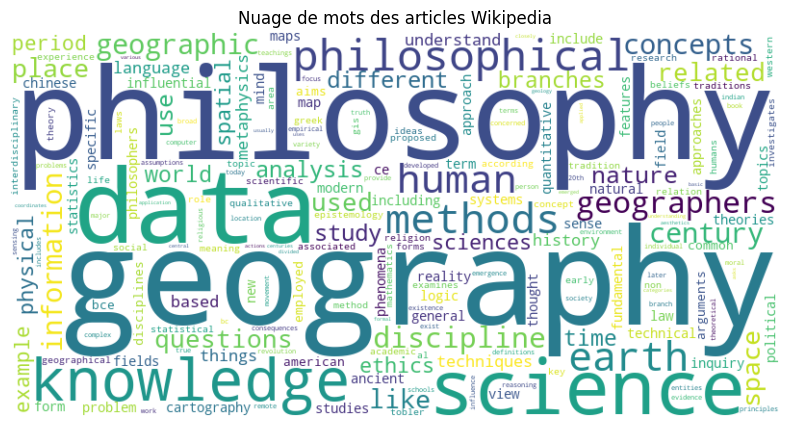

In [3]:
# Vectorisation des textes
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(documents)

# Extraction du vocabulaire
vocab = vectorizer.get_feature_names_out()
docs_indices = [X[i].nonzero()[1].tolist() for i in range(len(documents))]

# Affichage d’un nuage de mots (optionnel)
word_freq = np.asarray(X.sum(axis=0)).flatten()
word_freq_dict = dict(zip(vocab, word_freq))

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nuage de mots des articles Wikipedia")
plt.show()

# 3. Initialisation des paramètres (cf. article sur le SVI)

On utilise un modèle LDA avec `K` topics. Les paramètres `alpha` et `eta` sont des hyperparamètres de lois de Dirichlet.

## 🔢 Modèle probabiliste LDA (Latent Dirichlet Allocation)

Pour chaque document $d \in \{1, \dots, D\}$ :
- Le mélange des topics $\theta_d$ est tiré de :  
  $$\theta_d \sim \text{Dirichlet}(\alpha)$$
- Pour chaque mot $n \in \{1, \dots, N_d\}$ :
  - Le topic latent $z_{dn}$ est tiré de :
    $$z_{dn} \sim \text{Categorical}(\theta_d)$$
  - Le mot $w_{dn}$ est tiré de :
    $$w_{dn} \sim \text{Categorical}(\beta_{z_{dn}})$$

Avec :
- $K$ : nombre de topics
- $\beta_k$ : distribution de probas sur les mots pour le topic $k$, $\beta_k \sim \text{Dirichlet}(\eta)$

In [4]:
# SVI training (à faire AVANT le code des topics)
K = 3  # nombre de topics
alpha = np.ones(K)
eta = np.ones(len(vocab))
tau = 1.0
kappa = 0.7

# Initialisation
beta = np.random.dirichlet(eta, K)
lambda_t = beta.copy()

# 4. Fonctions SVI inspirées de l’article

On suit la méthode décrite dans l’article : boucle sur les documents (mini-batch = 1), estimation des paramètres locaux, puis mise à jour des paramètres globaux.
## ✏️ Approche variationnelle (approximation)

On approxime la postérieure intractable $p(\theta, z \mid w)$ par une distribution factorisée :

$$q(\theta, z) = q(\theta \mid \gamma) \prod_{n=1}^{N} q(z_n \mid \phi_n)$$

où :
- $\gamma$ sont les paramètres variationnels de $\theta$ (Dirichlet),
- $\phi_n$ est un vecteur de taille $K$ représentant les probas pour chaque topic $z_n$.

In [5]:
def learning_rate(t, tau=1.0, kappa=0.7):
    return (t + tau) ** (-kappa)

def svi_update(doc_words_idx, lambda_old, t):
    N = len(doc_words_idx)
    phi = np.ones((N, K)) / K
    gamma = alpha + N / K
    for _ in range(5):
        for n, w in enumerate(doc_words_idx):
            phi[n] = beta[:, w] * np.exp(np.log(gamma))
            phi[n] /= np.sum(phi[n])
        gamma = alpha + np.sum(phi, axis=0)
    lambda_hat = np.zeros_like(beta)
    for n, w in enumerate(doc_words_idx):
        lambda_hat[:, w] += phi[n]
    lambda_hat *= len(docs_indices)
    rho_t = learning_rate(t)
    lambda_new = (1 - rho_t) * lambda_old + rho_t * lambda_hat
    return lambda_new, phi, gamma


## 🔁 Mise à jour locale (document $d$)

À chaque itération, on met à jour :
- $$\phi_{nk} \propto \beta_{k, w_n} \cdot \exp\left( \psi(\gamma_k) \right)$$
- $$\gamma_k = \alpha_k + \sum_{n=1}^N \phi_{nk}$$

où $\psi$ est la fonction digamma (approximée ici par $\log$ dans ton code pour simplification).

## 🧮 Mise à jour globale (topics $\lambda$)

On met à jour les paramètres $\lambda$ des topics à l’aide d’une moyenne mobile :

$$\lambda^{(t)} = (1 - \rho_t) \cdot \lambda^{(t-1)} + \rho_t \cdot \hat{\lambda}$$

où :
- $\hat{\lambda}_{kv} = D \cdot \sum_{n=1}^{N_d} \phi_{nk} \cdot \mathbb{I}[w_n = v]$
- $\rho_t = (t + \tau)^{-\kappa}$ est le taux d’apprentissage.

In [6]:
lambda_current = lambda_t.copy()
for t in range(50):
    d = np.random.randint(0, len(docs_indices))
    doc = docs_indices[d]
    lambda_current, phi, gamma = svi_update(doc, lambda_current, t)

# 6. Analyse des résultats

## 6.1. Affichage des mots les plus représentatifs par topic

In [7]:
topic_names = [topic.replace("_", " ").title() for topic in topics]  # propre
df_topics = pd.DataFrame(lambda_current, columns=vocab, index=topic_names)

# -----------------------
# Afficher les top mots par topic
# -----------------------
def get_top_words_per_topic(df, top_n=5):
    top_words = {}
    for topic_name, row in df.iterrows():
        top_words[topic_name] = row.sort_values(ascending=False).head(top_n).index.tolist()
    return pd.DataFrame([
        {"Topic": topic, "Top Words": ", ".join(words)}
        for topic, words in top_words.items()
    ])

df_top_words = get_top_words_per_topic(df_topics, top_n=5)
display(df_top_words)

,Topic,Top Words
0,Geography,"concepts, computer, key, interdisciplinary, un..."
1,Data Science,"term, later, non, time, method"
2,Philosophy,"title, given, techniques, aspects, traditional"


## 6.2. Nuages de mots par topic

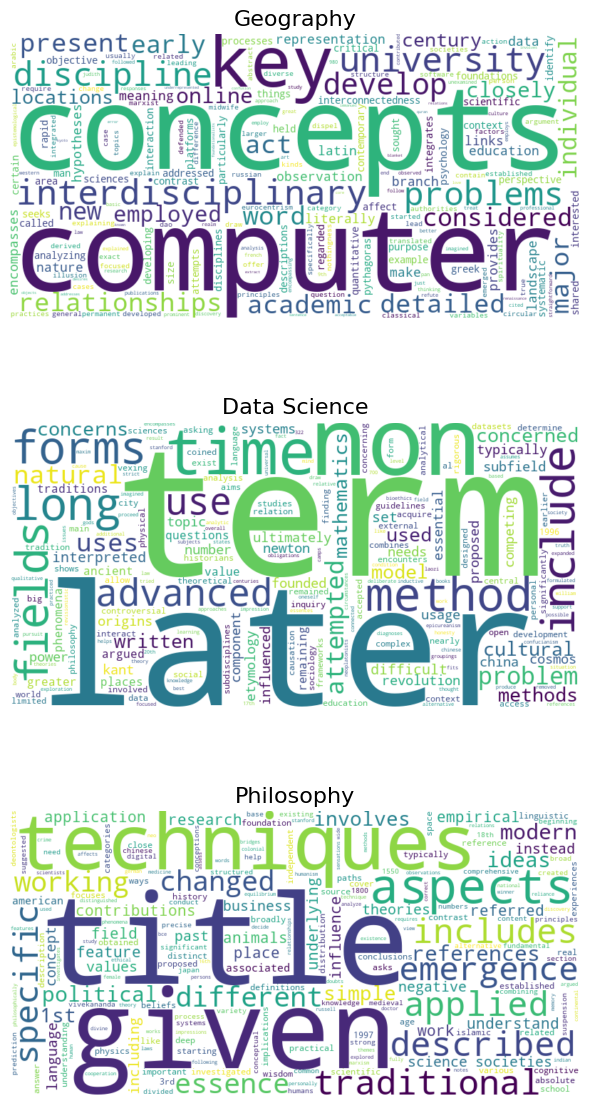

In [8]:
# -----------------------
# Générer les WordClouds pour chaque topic
# -----------------------
def plot_wordclouds_for_topics(df, n_cols=1):
    n_topics = df.shape[0]
    fig, axs = plt.subplots(n_topics, n_cols, figsize=(6 * n_cols, 4 * n_topics))
    if n_topics == 1:
        axs = [axs]

    for i, (topic_name, word_weights) in enumerate(df.iterrows()):
        word_freq = word_weights.to_dict()
        wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

        ax = axs[i] if n_topics > 1 else axs[0]
        ax.imshow(wc, interpolation='bilinear')
        ax.axis("off")
        ax.set_title(topic_name, fontsize=16)

    plt.tight_layout()
    plt.show()

plot_wordclouds_for_topics(df_topics)

## 6.3. Matrice des proportions de topics par document (θ)

On calcule les proportions de topics pour chaque document à l’aide de γ (gamma).
## 📊 Proportions de topics dans les documents

La distribution des topics dans un document est obtenue par :

$$\theta_d \approx \frac{\gamma_d}{\sum_k \gamma_{dk}}$$

In [9]:

# -----------------------
# Matrice de proportion de topics par document (θ_d)
# -----------------------
def compute_theta_matrix(docs_indices, lambda_topics, alpha):
    D = len(docs_indices)
    K = lambda_topics.shape[0]
    theta = np.zeros((D, K))

    for d, doc in enumerate(docs_indices):
        phi = np.ones((len(doc), K)) / K
        gamma = alpha + len(doc) / K

        for _ in range(5):
            for n, w in enumerate(doc):
                phi[n] = lambda_topics[:, w] * np.exp(np.log(gamma))
                phi[n] /= np.sum(phi[n])
            gamma = alpha + np.sum(phi, axis=0)

        theta[d, :] = gamma / np.sum(gamma)

    return pd.DataFrame(theta, columns=topic_names,
                        index=[f"Doc {i+1}" for i in range(D)])

df_theta = compute_theta_matrix(docs_indices, lambda_current, alpha)
display(df_theta)

,Geography,Data Science,Philosophy
Doc 1,0.288562,0.354659,0.356779
Doc 2,0.213087,0.391808,0.395106
Doc 3,0.369398,0.336962,0.293641


## 📌 Résumé

- On a implémenté le modèle LDA avec une version simplifiée de Stochastic Variational Inference (SVI).
- Chaque document est vu comme une combinaison de topics, chaque topic comme une distribution sur les mots.
- SVI permet une mise à jour efficace avec mini-batch (ici taille = 1), rendant l’algorithme scalable.